In [387]:
import pickle
import gzip
import math
import os
import time
import shutil
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter
from pathlib import Path
from torch import nn, tensor

from datasets import load_dataset, load_dataset_builder

In [365]:
import torchvision.transforms.functional as TF

from torch.utils.data import DataLoader
from torch.utils.data import default_collate

In [388]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
matplotlib.rcParams['image.cmap'] = 'gray'

In [2]:
name = 'fashion_mnist'
ds_builder = load_dataset_builder(name)

In [3]:
ds_builder.info.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [4]:
ds_dict = load_dataset(name)

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #2:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #3:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /home/ryvik/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [39]:
ds_dict

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [5]:
train, test = ds_dict['train'], ds_dict['test']

In [6]:
train[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

In [40]:
x,y = ds_builder.info.features

*Docs at: https://huggingface.co/docs/datasets/index*

In [11]:
img = train[0][x]

In [12]:
img

In [18]:
xb = train[:5][x]
yb = train[:5][y]

yb

[9, 0, 0, 3, 0]

In [19]:
train.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [22]:
features = train.features[y]
features

ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)

In [24]:
features.int2str(yb)

['Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top']

The collate function ca return a dictionary, the data loader will understand the format:

In [31]:
train

Dataset({
    features: ['image', 'label'],
    num_rows: 60000
})

In [28]:
train[:5][x]

[<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>]

In [45]:
type(train[0][x])

PIL.PngImagePlugin.PngImageFile

We need to transform the image to a tensor, with PyTorch PILToTensor, or rather ToTensor to have values between 0 and 1

In [54]:
TF.to_tensor(train[0][x]), TF.pil_to_tensor(train[0][x])

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [57]:
train[:2][y]

[9, 0]

In [145]:
next(iter(train))

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

In [330]:
def collate_fn(b): 
    return {x: torch.stack([TF.to_tensor(i[x]) for i in b]),
            y: tensor([l[y] for l in b])}  

In [133]:
train[0], train[:1]

({'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  'label': 9},
 {'image': [<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>],
  'label': [9]})

**Note**: *We can see above that for a single dict element, the 'image' section is not a list, so the collate function wouln't work, whereas for a slice of only one element it returns a list on only one element and it works.*

In [331]:
class WrapIter():
    def __init__(self, o):
        self.it_o = iter(o)
        self.len = 3
        self.num = 0
        print(self.num)
        
    def __iter__(self):
#         print(self.num)
#         if self.num > self.len:
#             raise StopIteration
#         else:
#             self.num +=1
#             print(self.num)
#             return iter(self.o)
        return self
    
    def __next__(self):
        self.num +=1
#         print(self.num)
        if self.num > self.len:
            raise StopIteration
        else:
            return next(self.it_o)
        

In [319]:
u = WrapIter(train)

0


In [320]:
uu = iter(u)

In [321]:
next(uu)

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

In [322]:
u = collate_fn(u)

In [323]:
u

{'image': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]]),
 'label': []}

In [324]:
u[x].shape, u[y]

(torch.Size([2, 1, 28, 28]), [])

In [142]:
DataLoader?

In [332]:
dl = DataLoader(train, collate_fn=collate_fn, batch_size=16)

In [333]:
b = next(iter(dl))

In [334]:
b[x].shape, b[y]

(torch.Size([16, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

But we can use directly use a transform and not mofidy the collate function:

In [336]:
def transforms(b):
    b[x] = [TF.to_tensor(i) for i in b[x]]
    return b

In [337]:
tds = train.with_transform(transforms)
dl = DataLoader(tds, batch_size=16)

In [338]:
b = next(iter(dl))
b[x].shape, b[y]

(torch.Size([16, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

In [350]:
def _transformi(b): b[x] = [torch.flatten(TF.to_tensor(i)) for i in b[x]]

In [359]:
def inplace(f):
    def g(b):
        f(b)
        return b
    return g

In [360]:
transformi = inplace(_transformi) 

In [361]:
r = train.with_transform(transformi)

In [362]:
r[0][x].shape

torch.Size([784])

In [363]:
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(i)) for i in b[x]]

In [364]:
tdsf = train.with_transform(transformi) # transformed data set flattened
r = tdsf[0]
r[x].shape, r[y]

(torch.Size([784]), 9)

In [371]:
def collate_dict(ds):
    get = itemgetter(*ds.features)
    def _f(b): return get(default_collate(b))
    return _f

In [372]:
dlf = DataLoader(tdsf, batch_size=4, collate_fn=collate_dict(tdsf))
xb,yb = next(iter(dlf))
xb.shape,yb

(torch.Size([4, 784]), tensor([9, 0, 0, 3]))

### Plotting

In [376]:
b = next(iter(dl))

In [380]:
xb = b['image']
xb.shape

torch.Size([16, 1, 28, 28])

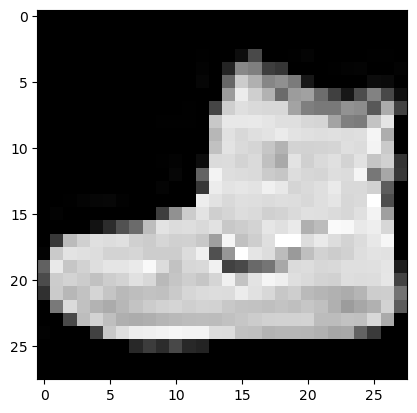

In [389]:
img = xb[0]
plt.imshow(img.squeeze());

### For Miniai

In [1]:
#| default_exp datasets

In [1]:
#|export
from __future__ import annotations
import math,numpy as np,matplotlib.pyplot as plt
from operator import itemgetter
from itertools import zip_longest
import fastcore.all as fc

from torch.utils.data import default_collate

from miniai.training import *

In [3]:
#|export
def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

In [4]:
#|export
def collate_dict(ds):
    get = itemgetter(*ds.features)
    def _f(b): return get(default_collate(b))
    return _f

In [5]:
#|export
@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    if fc.hasattrs(im, ('cpu','permute','detach')):
        im = im.detach().cpu()
        if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=np.array(im)
    if im.shape[-1]==1: im=im[...,0]
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    if noframe: ax.axis('off')
    return ax

In [6]:
#|export
@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows:int=1, # Number of rows in returned axes grid
    ncols:int=1, # Number of columns in returned axes grid
    figsize:tuple=None, # Width, height in inches of the returned figure
    imsize:int=3, # Size (in inches) of images that will be displayed in the returned figure
    suptitle:str=None, # Title to be set to returned figure
    **kwargs
): # fig and axs
    "A figure and set of subplots to display images of `imsize` inches"
    if figsize is None: figsize=(ncols*imsize, nrows*imsize)
    fig,ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if suptitle is not None: fig.suptitle(suptitle)
    if nrows*ncols==1: ax = np.array([ax])
    return fig,ax

In [7]:
#|export
@fc.delegates(subplots)
def get_grid(
    n:int, # Number of axes
    nrows:int=None, # Number of rows, defaulting to `int(math.sqrt(n))`
    ncols:int=None, # Number of columns, defaulting to `ceil(n/rows)`
    title:str=None, # If passed, title set to the figure
    weight:str='bold', # Title font weight
    size:int=14, # Title font size
    **kwargs,
): # fig and axs
    "Return a grid of `n` axes, `rows` by `cols`"
    if nrows: ncols = ncols or int(np.floor(n/nrows))
    elif ncols: nrows = nrows or int(np.ceil(n/ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.floor(n/nrows))
    fig,axs = subplots(nrows, ncols, **kwargs)
    for i in range(n, nrows*ncols): axs.flat[i].set_axis_off()
    if title is not None: fig.suptitle(title, weight=weight, size=size)
    return fig,axs

In [8]:
#|export
@fc.delegates(subplots)
def show_images(ims:list, # Images to show
                nrows:int|None=None, # Number of rows in grid
                ncols:int|None=None, # Number of columns in grid (auto-calculated if None)
                titles:list|None=None, # Optional list of titles for each image
                **kwargs):
    "Show all images `ims` as subplots with `rows` using `titles`"
    axs = get_grid(len(ims), nrows, ncols, **kwargs)[1].flat
    for im,t,ax in zip_longest(ims, titles or [], axs): show_image(im, ax=ax, title=t)

In [1]:
#|export
class DataLoaders:
    def __init__(self, *dls): self.train,self.valid = dls[:2]

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        f = collate_dict(dd['train'])
        return cls(*get_dls(*dd.values(), bs=batch_size, collate_fn=f, **kwargs))

In [23]:
import nbdev; nbdev.nbdev_export()